In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib # 웹과 관련된 데이터를 쉽게 다룰 수 있는 모듈

from matplotlib import pyplot as plt
import tensorflow as tf

## 1. 사진 준비

In [2]:
# 내 사진 불러오기
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/pengsoo.jpeg'   
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1297, 1000, 3)


## 2. Image Segmentation

In [3]:
#DeepLab 
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

# __init__()대신, tar file로 그래프구조 graph_def를 
# tf.compat.v1.import_graph_def를 통해 불러들여 사용
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# Pretrained weight 불러오기
# 모델: PASCAL VOC 2012
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
# 이미지 입력
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(1297, 1000, 3) (513, 395, 3) 16


라벨이 없어서(?) 펭수 캐릭터는 인식 못하고, 그 뒤에 있는 화분을 인식함

In [12]:
#  DeepLab은 PASCAL VOC의 라벨 종류
LABEL_NAMES = [
     'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


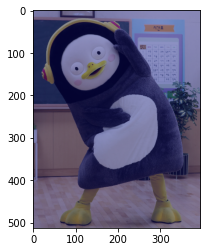

In [13]:
# 사람 라벨만 뽑기 (15)
# 마스크 만들기 -> 시각화
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 사람(15)만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 정규화(normalization)
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 3. 세그멘테이션 결과 원래 크기로 복원

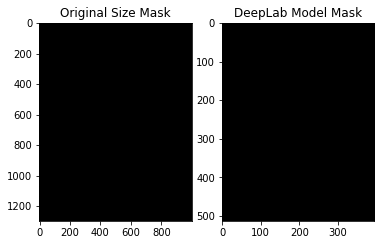

In [14]:
# mask(세그멘테이션 결과) 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap = plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap = plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 4. 배경 Blur

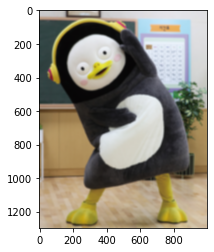

In [15]:
# 전체 블러링
img_orig_blur = cv2.blur(img_orig, (13, 13)) # Blurring kernel size
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

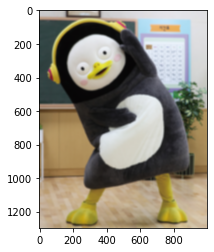

In [16]:
# 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 블러된 배경과 원본 합성

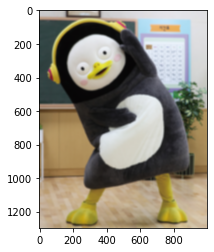

In [17]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()